In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scanpy as sc 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [3]:
adata = sc.read_h5ad('/Users/koush/Desktop/training_data/mouse_brain_wt_slideseq.h5ad')
adata

AnnData object with n_obs × n_vars = 23409 × 3311
    obs: 'cell_type', 'cell_type_int', 'seurat_clusters', 'umap_1', 'umap_2', 'author_cell_type'
    uns: 'cell_thresholds', 'received_ligands', 'received_ligands_tfl'
    obsm: 'X_umap', 'spatial', 'spatial_unscaled'
    layers: 'imputed_count', 'normalized_count', 'raw_count'

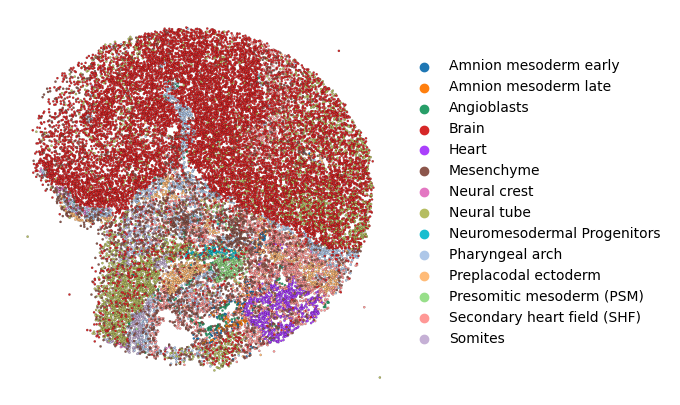

In [4]:
plt.rcParams["figure.figsize"] = (5, 5)
plt.rcParams['figure.dpi'] = 100
sc.pl.embedding(adata, basis='spatial', color='cell_type', 
    frameon=False, edgecolor='black', s=10, linewidth=0.1, title='')

In [5]:
import sys
sys.path.append('../../src/')

In [6]:
import celloracle as co

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [7]:
adata.X.max()

6.6688848

In [8]:
adata.layers["raw_count"].max()

786.51685

In [9]:
oracle = co.Oracle()

adata.X = adata.layers["raw_count"].copy()

oracle.import_anndata_as_raw_count(
    adata=adata,
    cluster_column_name="cell_type",
    embedding_name="X_umap"
)

oracle.pcs = [True]
oracle.k_knn_imputation = 1
oracle.knn = 1

In [10]:
base_GRN = co.data.load_mouse_promoter_base_GRN()
oracle.import_TF_data(TF_info_matrix=base_GRN)

Loading prebuilt promoter base-GRN. Version: mm10_gimmemotifsv5_fpr2


In [100]:
import decoupler as dc
net = dc.get_collectri(organism='mouse', split_complexes=False)

#{
#    'TF': list([TARGET_GENES]),
#}

extra_grn = {
    'Tbx6': np.unique(list(net[net.source == 'Tbx6'].target.values) + ['Foxn1']),
    'Sox2': np.unique(list(net[net.source == 'Sox2'].target.values)),
    'Foxn1': np.unique(list(net[net.source == 'Foxn1'].target.values) + ['Sox2']),
}

oracle.addTFinfo_dictionary(co.utility.inverse_dictionary(extra_grn))

  0%|          | 0/145 [00:00<?, ?it/s]

In [102]:
%%time

links = oracle.get_links(
    cluster_name_for_GRN_unit="cell_type", 
    alpha=5,
    verbose_level=1
)

100%|██████████| 14/14 [25:09<00:00, 107.80s/it]

CPU times: user 13min 34s, sys: 42.8 s, total: 14min 17s
Wall time: 25min 10s


In [110]:
links.links_dict['Somites'].query('source == "Foxn1" and target == "Sox2"')

source target  coef_mean  coef_abs         p     -logp
93955  Foxn1   Sox2  -0.028476  0.028476  0.000001  5.962715

In [111]:
links.filter_links(p=0.001, weight="coef_abs", threshold_number=2000)

In [112]:
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
# oracle.fit_GRN_for_simulation(
#     alpha=10, 
#     use_cluster_specific_TFdict=True
# )

In [113]:
import pickle

with open('/Users/koush/Desktop/training_data/mouse_brain_wt_slideseq_colinks.pkl', 'wb') as f:
    pickle.dump(links.links_dict, f)

In [114]:

oracle.to_hdf5("/Users/koush/Desktop/training_data/mouse_brain_wt_slideseq.celloracle.oracle")
links.to_hdf5(file_path="/Users/koush/Desktop/training_data/mouse_brain_wt_slideseq.celloracle.links")

In [22]:
oracle = co.load_hdf5("/Users/koush/Desktop/training_data/mouse_brain_wt_slideseq.celloracle.oracle")

In [115]:
sc.pp.pca(oracle.adata)
sc.pp.neighbors(oracle.adata, use_rep="X_pca")
sc.tl.louvain(oracle.adata, resolution=0.5)

In [116]:
sc.tl.paga(oracle.adata, groups="cell_type")

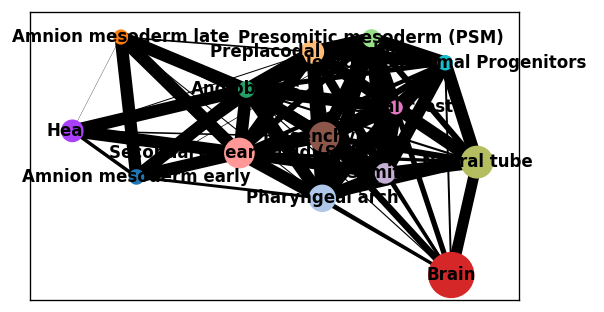

In [117]:
sc.pl.paga(oracle.adata)

In [118]:
sc.tl.draw_graph(oracle.adata, init_pos='paga', random_state=123)

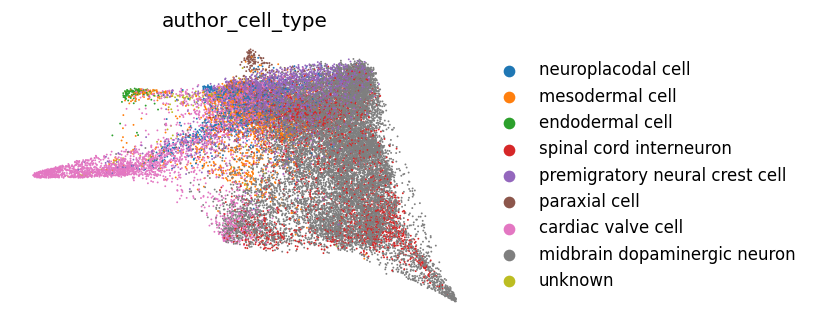

In [119]:
%matplotlib inline
sc.pl.draw_graph(oracle.adata, color='author_cell_type', frameon=False)
plt.show()

In [120]:
links = co.load_hdf5("/Users/koush/Desktop/training_data/mouse_brain_wt_slideseq.celloracle.links")

In [121]:
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)

In [122]:
oracle.fit_GRN_for_simulation(
    alpha=1,
    use_cluster_specific_TFdict=True
)

  0%|          | 0/14 [00:00<?, ?it/s]

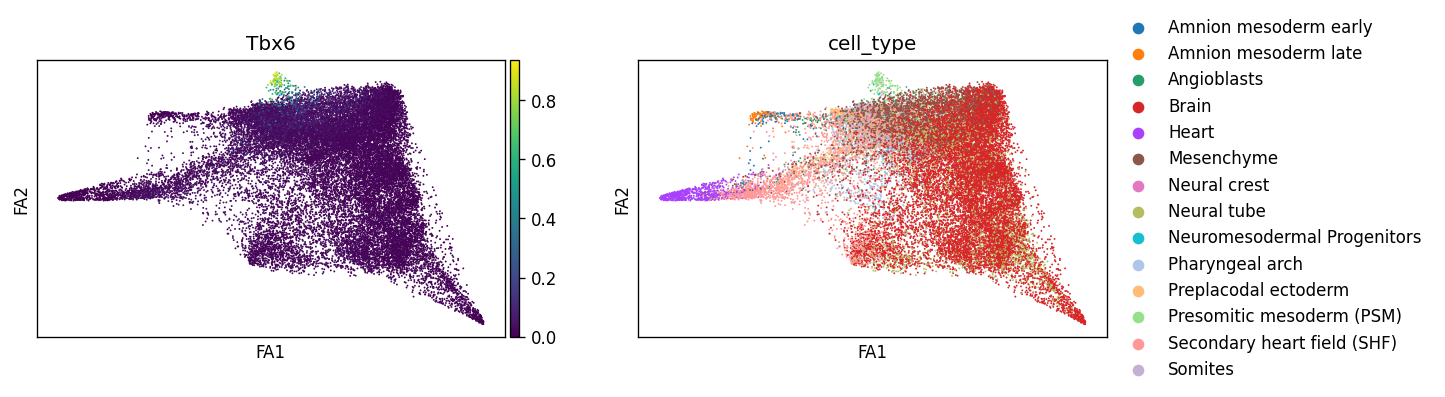

In [123]:
goi = "Tbx6"
sc.pl.draw_graph(oracle.adata, color=[goi, oracle.cluster_column_name],
    layer="imputed_count", use_raw=False, cmap="viridis")

In [124]:
oracle.simulate_shift(
    perturb_condition={goi: 0.0},
    n_propagation=4
)

In [125]:
# Get transition probability
oracle.estimate_transition_prob(
    n_neighbors=200,
    knn_random=True,
    sampled_fraction=1
)

# Calculate embedding
oracle.calculate_embedding_shift(sigma_corr=0.05)

In [66]:
dfo = pd.DataFrame(oracle.adata.layers['delta_X'], columns=oracle.adata.var_names, index=oracle.adata.obs.index)

<Axes: ylabel='cell_type'>

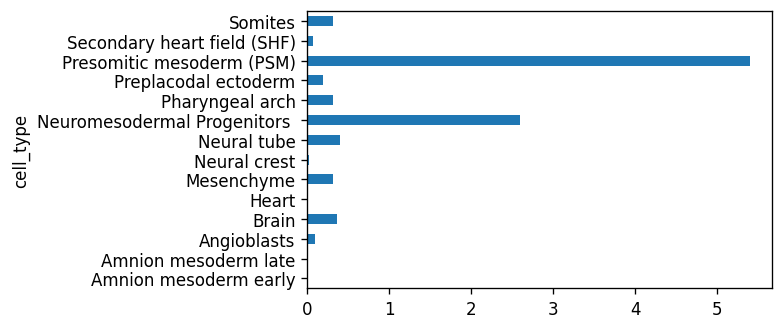

In [99]:
plt.rcParams['figure.figsize'] = [5, 3]
plt.rcParams['figure.dpi'] = 120

dfo.join(oracle.adata.obs.cell_type).groupby('cell_type').mean().abs().sum(1).plot(kind='barh')

In [126]:
dfo[['Sox2']].join(oracle.adata.obs.cell_type).groupby('cell_type').mean().sort_values('Sox2', ascending=False)

Sox2
cell_type                             
Neuromesodermal Progenitors   0.061363
Neural tube                   0.003748
Somites                       0.002757
Brain                         0.002707
Amnion mesoderm early         0.000000
Amnion mesoderm late          0.000000
Angioblasts                   0.000000
Heart                         0.000000
Mesenchyme                    0.000000
Neural crest                  0.000000
Pharyngeal arch               0.000000
Preplacodal ectoderm          0.000000
Presomitic mesoderm (PSM)     0.000000
Secondary heart field (SHF)   0.000000

In [127]:
dfo[['Sox2', 'Pax6', 'Crabp2', 'Arg1', 'Meox1', 'Foxn1']].join(oracle.adata.obs.cell_type).groupby('cell_type').mean().sort_values('Sox2', ascending=False)

Sox2      Pax6    Crabp2      Arg1  \
cell_type                                                              
Neuromesodermal Progenitors   0.061363  0.008559  0.089532  0.000000   
Neural tube                   0.003748  0.001610  0.010906  0.000308   
Somites                       0.002757  0.001369  0.003642 -0.000552   
Brain                         0.002707  0.000729  0.006914  0.000000   
Amnion mesoderm early         0.000000  0.000000  0.000000  0.000000   
Amnion mesoderm late          0.000000  0.000000  0.000000  0.000000   
Angioblasts                   0.000000  0.000000  0.000041  0.000000   
Heart                         0.000000  0.000000  0.000000  0.000000   
Mesenchyme                    0.000000  0.000000  0.002373  0.000000   
Neural crest                  0.000000  0.000000  0.000000  0.000000   
Pharyngeal arch               0.000000  0.000000  0.001469  0.000073   
Preplacodal ectoderm          0.000000  0.000000  0.003577  0.000000   
Presomitic mesoderm (PSM)     0.000000  0.000000  0.000000  0.000000   
Secondary heart field (SHF)   0.000000  0.000000  0.000000  0.000000   

                                 Meox1  Foxn1  
cell_type                                      
Neuromesodermal Progenitors   0.000000    0.0  
Neural tube                   0.000000    0.0  
Somites                      -0.000116    0.0  
Brain                         0.000000    0.0  
Amnion mesoderm early         0.000000    0.0  
Amnion mesoderm late          0.000000    0.0  
Angioblasts                   0.000000    0.0  
Heart                         0.000000    0.0  
Mesenchyme                    0.000000    0.0  
Neural crest                  0.000000    0.0  
Pharyngeal arch               0.000000    0.0  
Preplacodal ectoderm          0.000000    0.0  
Presomitic mesoderm (PSM)     0.000000    0.0  
Secondary heart field (SHF)   0.000000    0.0

In [41]:
adata

AnnData object with n_obs × n_vars = 23409 × 3311
    obs: 'cell_type', 'cell_type_int', 'seurat_clusters', 'umap_1', 'umap_2', 'author_cell_type'
    uns: 'cell_thresholds', 'received_ligands', 'received_ligands_tfl', 'cell_type_colors'
    obsm: 'X_umap', 'spatial', 'spatial_unscaled'
    layers: 'imputed_count', 'normalized_count', 'raw_count'

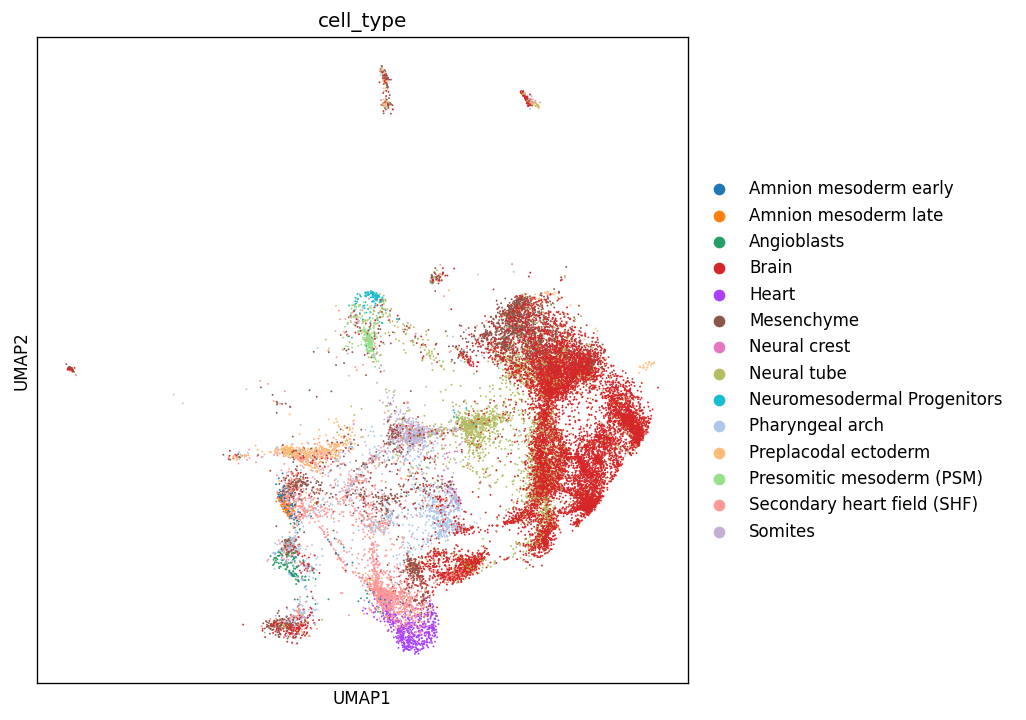

In [39]:
plt.rcParams['figure.figsize'] = [7, 7]
plt.rcParams['figure.dpi'] = 120
sc.pl.umap(adata, color='cell_type')

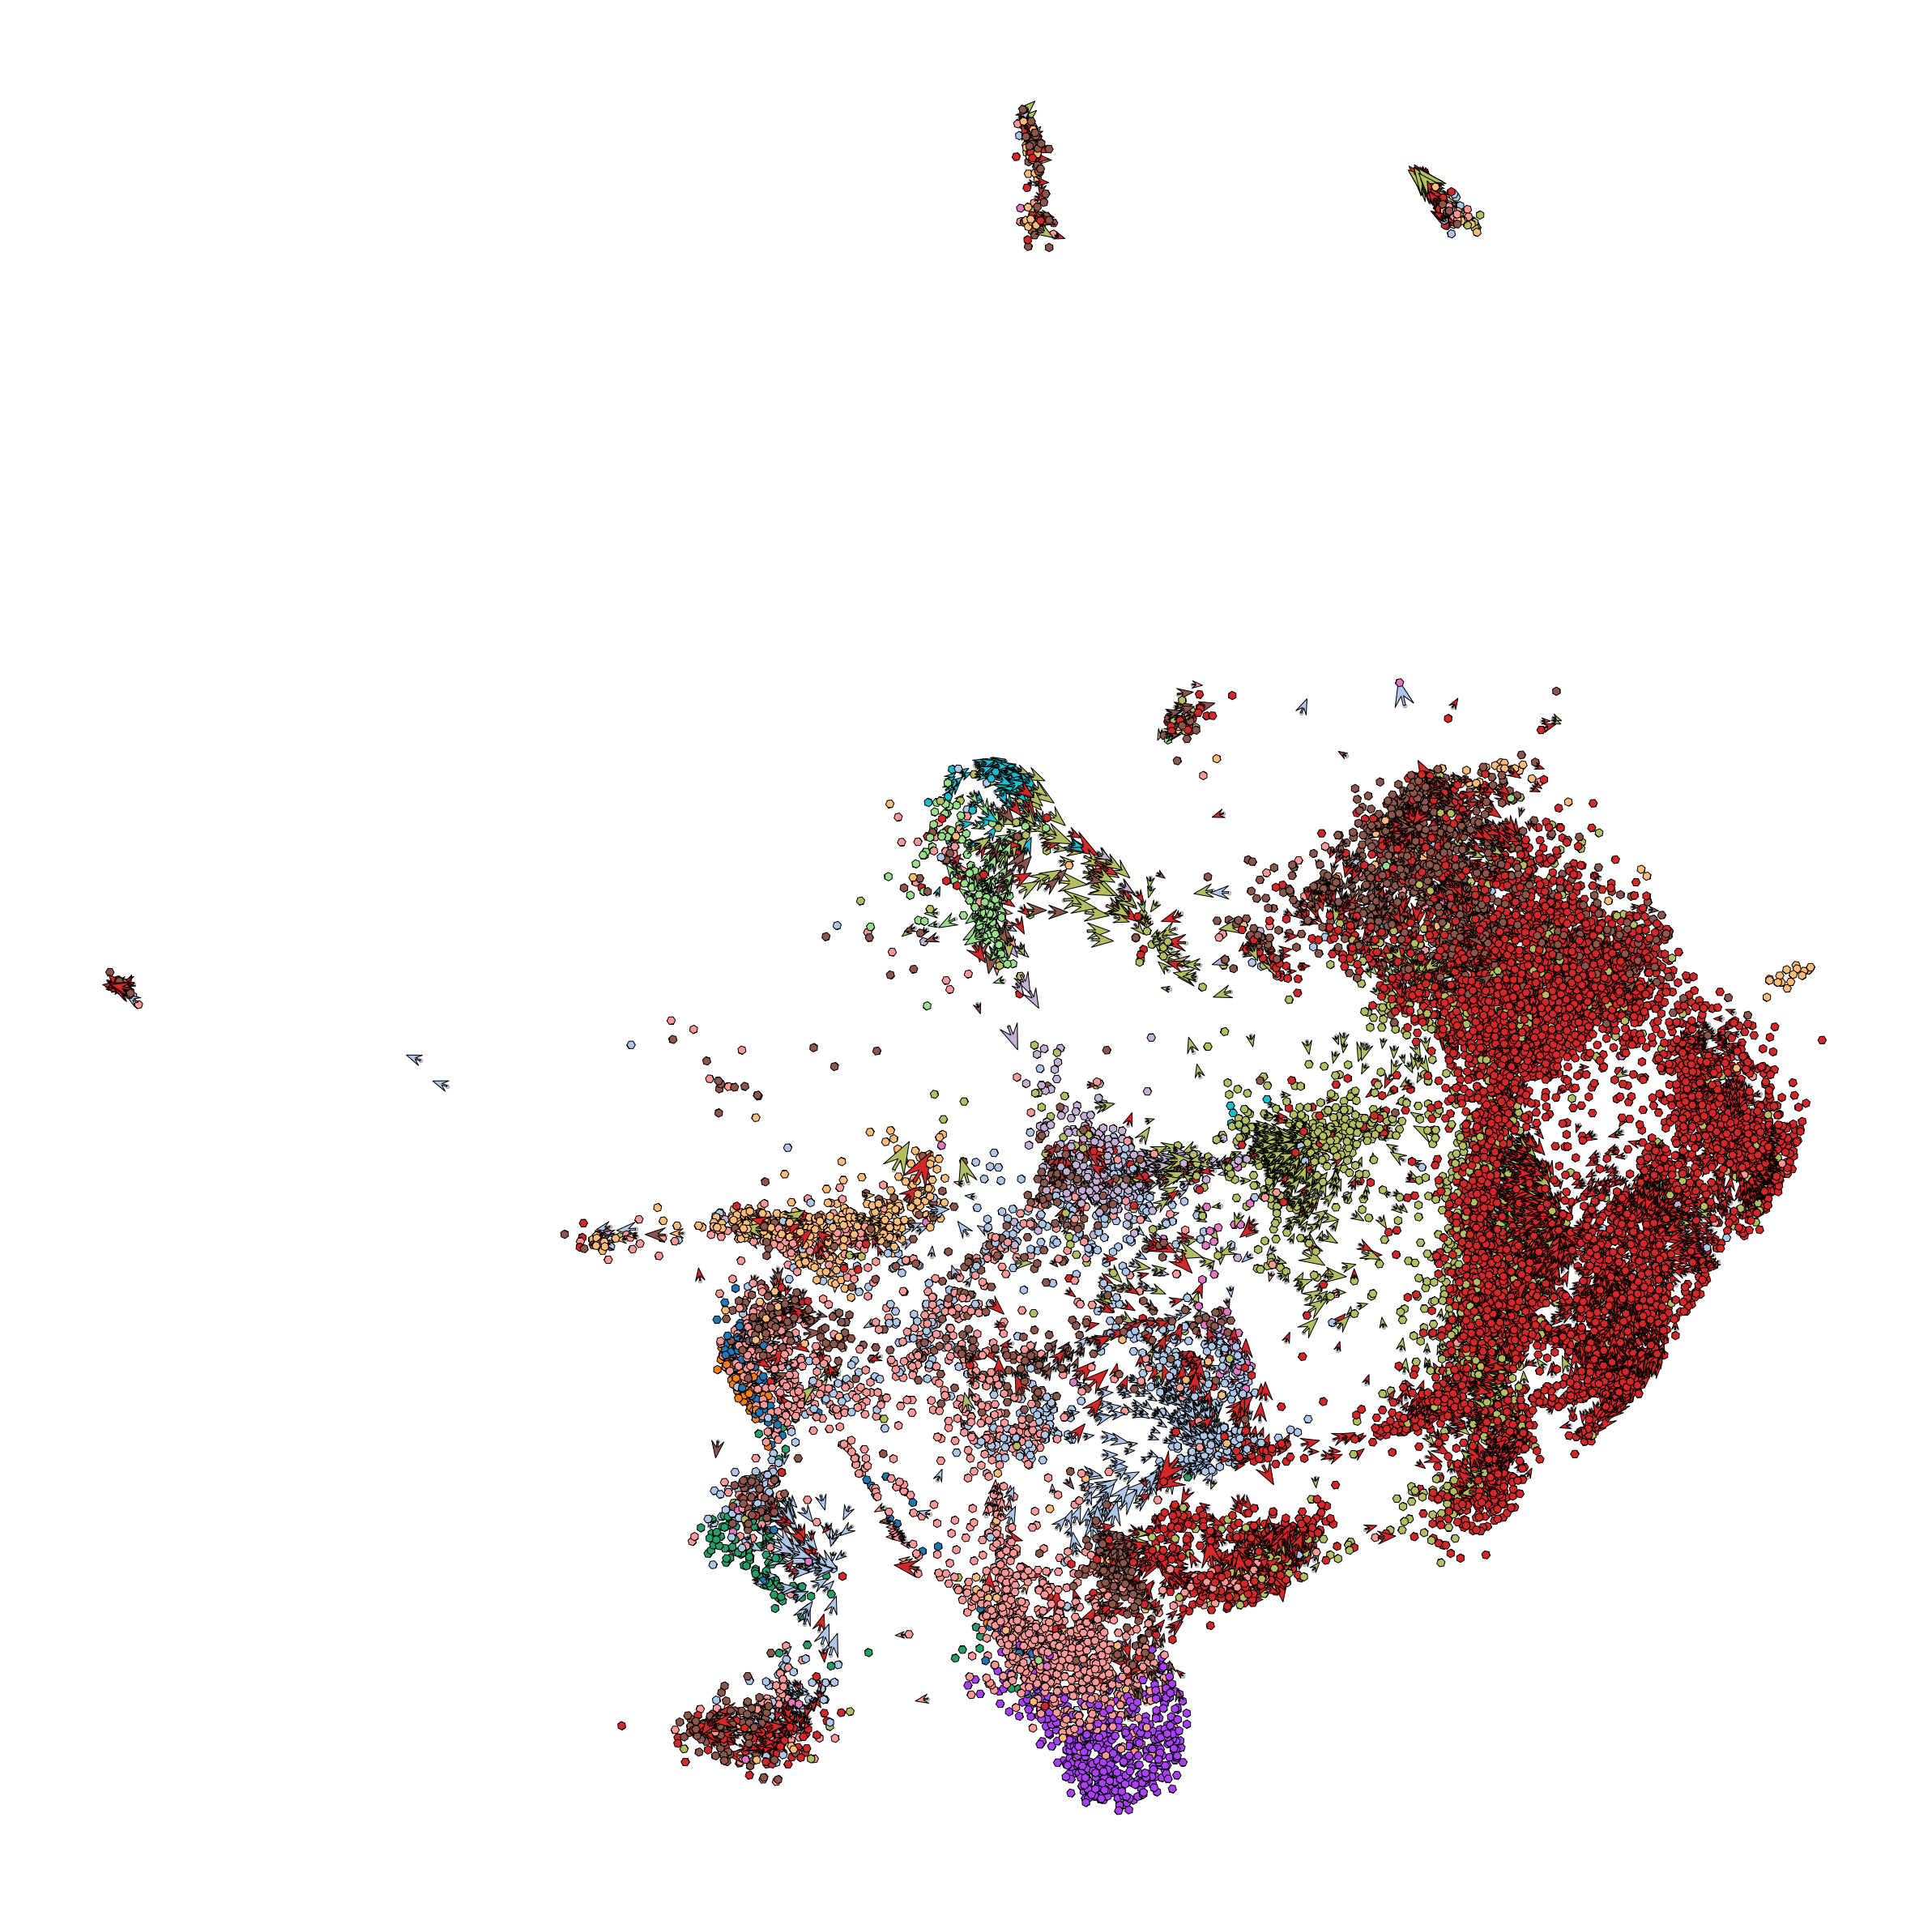

In [83]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['figure.dpi'] = 300

oracle.plot_quiver(scale=80, s=1)

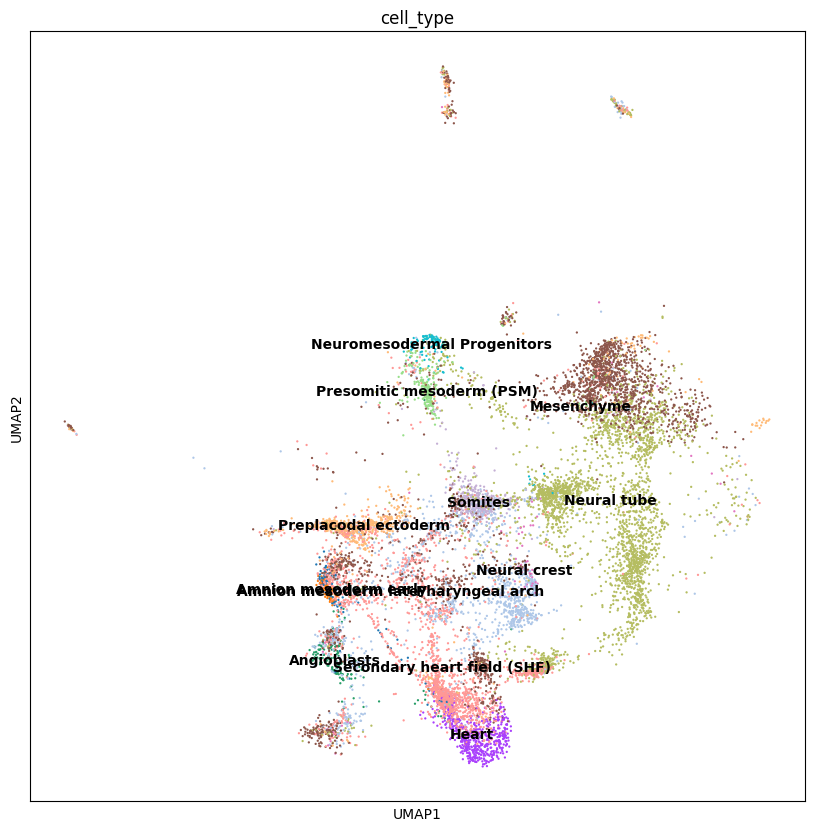

In [78]:
sc.pl.umap(adata[~adata.obs.cell_type.isin(['Brain'])], color='cell_type', legend_loc='on data')